# Exercise 5
### Lars Kuehmichel, Nicolas Wolf

### 1 GP Optimization of a Toy Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sobol
import GPy
import optunity
import copy

##### 1. Implementation of $f(x, y)$, plot and description of uniform sampling

In [2]:
def f(x, y):
    return x ** 2 - x + y ** 2 + y - np.cos(2 * np.pi * x - np.pi) - np.cos(2 * np.pi * y + np.pi) + 2.5

def ff(q):
    z = f(q[:, 0], q[:, 1])
    return np.expand_dims(z, -1)

In [3]:
def plot_f(mark_max=False, extra_points=None):
    x = y = np.linspace(-6, 6, 200)
    xx, yy = np.meshgrid(x, y)

    z = f(xx, yy)

    plt.figure(figsize=(9, 9))
    plt.imshow(z, extent=(-6, 6, -6, 6))

    if extra_points is not None:
        colors = list(range(len(extra_points)))
        plt.scatter(extra_points[:, 0], extra_points[:, 1], marker="x", c=colors, cmap="autumn")

    if mark_max:
        i = np.argmax(z)
        ii = np.unravel_index(i, xx.shape)
        plt.plot(xx[ii], yy[ii], marker="o", color="magenta", markersize=25)

    plt.title("$f(x, y)$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

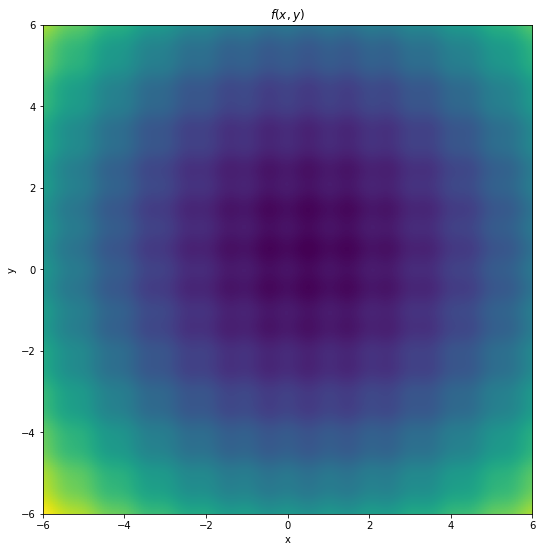

In [4]:
plot_f()

In [5]:
x = np.random.uniform(-6, 6, 60)
y = np.random.uniform(-6, 6, 60)
z = f(x, y)

stats.describe(z)

DescribeResult(nobs=60, minmax=(3.5542115768289557, 66.2055330329148), mean=27.308470981059642, variance=223.0766657676103, skewness=0.2537177042220334, kurtosis=-0.37882517037190855)

##### 2. Expected improvement

In [6]:
def expected_improvement(gp, q, e):
    mu, var = gp(q)
    sig = np.sqrt(var)
    g = (e - mu) / sig
    return sig * (g * stats.norm.cdf(g) + stats.norm.pdf(g))

##### 3. and 4. Sobol sampled initial training set

In [7]:
def semi_random_sobol(n, *, lo, hi, split=False):
    if not isinstance(lo, np.ndarray):
        lo = np.array(lo)
    if not isinstance(hi, np.ndarray):
        hi = np.array(hi)

    s = np.array([
        sobol.i4_sobol(2, i)[0] for i in range(n)
    ])

    q = s * (hi - lo) + lo

    if split:
        x = q[:, 0]
        y = q[:, 1]

        return x, y

    return q

In [8]:
q = semi_random_sobol(30, lo=(-6, -6), hi=(6, 6))
z = ff(q)

print(q.shape)
print(z.shape)

(30, 2)
(30, 1)


##### 5. GPy model and kernel

In [9]:
kernel = GPy.kern.RBF(2) + GPy.kern.White(2)

model = GPy.models.GPRegression(q, z, kernel=kernel)
model.optimize()

In [10]:
optunity.available_solvers()

['grid search', 'random search', 'nelder-mead', 'sobol', 'particle swarm']

##### 6., 7., and 8. Optimization with a single utility function over 30 iterations

The uncertainty in the resulting function is very high, and it does not accurately follow the
objective function.

In [11]:
e_best = np.max(z)

predicted_mu = []
predicted_var = []
actual = []

for i in range(30):
    def utility(x, y):
        q = np.stack((x, y), axis=-1)
        q = np.expand_dims(q, 0)
        return expected_improvement(model.predict, q, e_best)

    m = optunity.maximize(utility, num_evals=50, solver_name="sobol", x=[-6, 6], y=[-6, 6])

    q_best = np.array([
        [m[0]["x"], m[0]["y"]]
    ])

    f_best = ff(q_best)
    e_best = np.squeeze(f_best)

    q = np.vstack((q, q_best))
    z = np.vstack((z, f_best))

    model = GPy.models.GPRegression(q, z, kernel=kernel)
    model.optimize()

    mu, var = model.predict(q_best)
    predicted_mu.append(mu)
    predicted_var.append(var)
    actual.append(np.squeeze(e_best))



 /home/lars/code/python/AML/.venv/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


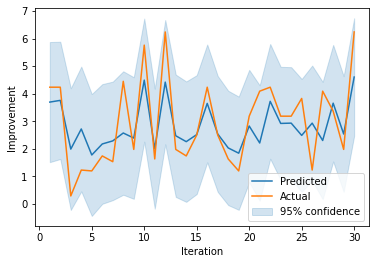

In [12]:
predicted_mu = np.squeeze(np.array(predicted_mu))
predicted_sig = np.squeeze(np.sqrt(predicted_var))
actual = np.squeeze(np.array(actual))

iterations = 1 + np.arange(30)

confidence = 1.95996
confidence_percent = 95

plt.plot(iterations, predicted_mu, label="Predicted", color="C0")
plt.fill_between(iterations,
                 predicted_mu - confidence * predicted_sig,
                 predicted_mu +  confidence * predicted_sig,
                 label=f"{confidence_percent}% confidence",
                 color="C0",
                 alpha=0.2)
plt.plot(iterations, actual, label="Actual", color="C1")
plt.xlabel("Iteration")
plt.ylabel("Improvement")
plt.legend()
plt.show()

##### 9. Marking the GP function values and the global optimum

We marked the global optimum with a big magenta circle, and the explored points with an x,
ranging in color from red (small iteration number) to yellow (high iteration number).

We can see that the optimization does not explore very far, and instead stays within local maxima.

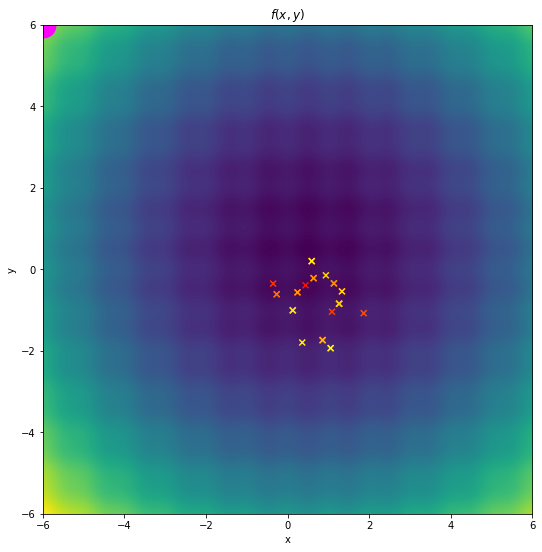

In [13]:
plot_f(mark_max=True, extra_points=q[30:])

##### 10. Repeat the experiment with alternating utility functions

The function is now approximated a lot better, and with a lot higher accuracy. The 95% confidence
interval is barely even visible in the plot. We can also see that the model is much more explorative,
since it moves to the edge of the plot (where high function values are found) very quickly.

In [14]:
q = semi_random_sobol(30, lo=(-6, -6), hi=(6, 6))
z = ff(q)

print(q.shape)
print(z.shape)

(30, 2)
(30, 1)


In [15]:
kernel = GPy.kern.RBF(2) + GPy.kern.White(2)

model = GPy.models.GPRegression(q, z, kernel=kernel)
model.optimize()

pre_opt = copy.deepcopy(model)

In [16]:
e_best = np.max(z)

predicted_mu = []
predicted_var = []
actual = []

for i in range(30):
    if i % 2 == 0:
        def utility(x, y):
            q = np.stack((x, y), axis=-1)
            q = np.expand_dims(q, 0)
            return expected_improvement(model.predict, q, e_best)
    else:
        def utility(x, y):
            q = np.stack((x, y), axis=-1)
            q = np.expand_dims(q, 0)
            mu, var = model.predict(q)
            return var

    m = optunity.maximize(utility, num_evals=50, solver_name="sobol", x=[-6, 6], y=[-6, 6])

    q_best = np.array([
        [m[0]["x"], m[0]["y"]]
    ])

    f_best = ff(q_best)
    e_best = np.squeeze(f_best)

    q = np.vstack((q, q_best))
    z = np.vstack((z, f_best))

    model = GPy.models.GPRegression(q, z, kernel=kernel)
    model.optimize()

    mu, var = model.predict(q_best)
    predicted_mu.append(mu)
    predicted_var.append(var)
    actual.append(np.squeeze(e_best))

 /home/lars/code/python/AML/.venv/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


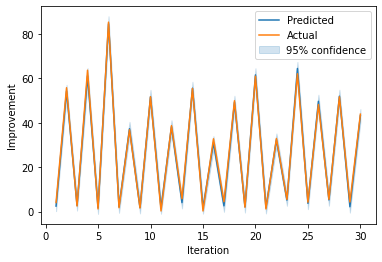

In [17]:
predicted_mu = np.squeeze(np.array(predicted_mu))
predicted_sig = np.squeeze(np.sqrt(predicted_var))
actual = np.squeeze(np.array(actual))

iterations = 1 + np.arange(30)

confidence = 1.95996
confidence_percent = 95

plt.plot(iterations, predicted_mu, label="Predicted", color="C0")
plt.fill_between(iterations,
                 predicted_mu - confidence * predicted_sig,
                 predicted_mu +  confidence * predicted_sig,
                 label=f"{confidence_percent}% confidence",
                 color="C0",
                 alpha=0.2)
plt.plot(iterations, actual, label="Actual", color="C1")
plt.xlabel("Iteration")
plt.ylabel("Improvement")
plt.legend()
plt.show()

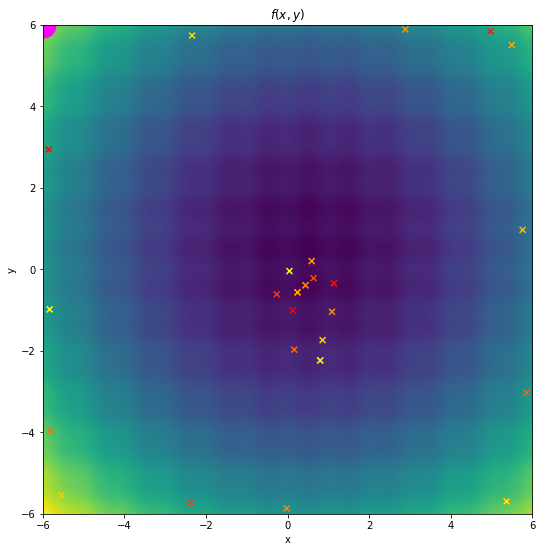

In [18]:
plot_f(mark_max=True, extra_points=q[30:])

##### 11. Plotting the GP model before and after optimization

 /home/lars/code/python/AML/.venv/lib/python3.9/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7ff840f39610>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7ff767f80610>]}

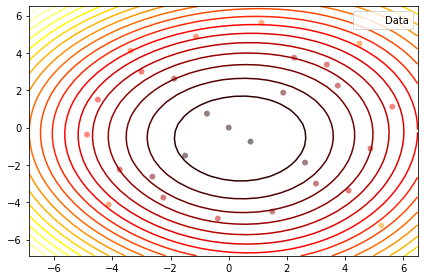

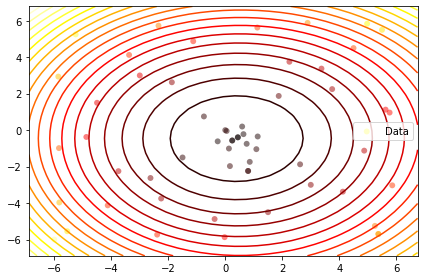

In [19]:
pre_opt.plot()
model.plot()

##### 12. Requirements for the function f(x, y)

$f(x, y)$ must be a smooth function.

### 2. Reconstruction of a Corrupted Image

The code uses a conjugate gradient method to apply the inverse of $K$. It uses sparse matrices, which is a good
idea since most entries in $K$ are zero (only near-neighbours are non-zero).

In [20]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial

In [21]:
# opt_print = lambda *args, **kwargs: None  # silence output

opt_print = print # for debugging

In [22]:
def gaussian_kernel(data, sigma, max_distance):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert sigma > 0

    factor = -0.5 / (sigma ** 2)
    limit = np.exp(factor * max_distance ** 2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(factor * np.sum((data - k) ** 2, axis=1))
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K

In [23]:
def generalized_exponential_kernel(data, sigma, gamma, max_distance):
    assert len(data.shape) == 2
    assert sigma > 0
    assert gamma > 0

    limit = np.exp(max_distance ** 2 / sigma ** 2)

    K = []
    for k in data:
        d = np.exp(-np.sqrt(np.sum((data - k) ** 2, axis=-1) / (sigma ** 2)) ** gamma)
        d[d < limit] = 0.0
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K


In [24]:
def compute_alpha_gaussian(train_x, train_y, tau, sigma, max_distance, verbose=False):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :param verbose: Print debugging information?
    :return: alpha vector
    """
    if verbose: print("Building input kernel matrix")
    K = gaussian_kernel(train_x, sigma, max_distance)
    if verbose: print("Sparsity is: %.2f%%" % (
            float(100 * K.nnz) / (K.shape[0] * K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:, None])
    if verbose: print("Solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    if verbose: print("Done computing alpha")
    return alpha[0]

def compute_alpha(train_x, train_y, tau, sigma, gamma, max_distance, verbose=False):
    if verbose:
        print("Building input kernel matrix")
    K = generalized_exponential_kernel(train_x, sigma, gamma, max_distance)
    if verbose:
        print(f"Sparsity is {(100.0 * K.nnz) / (K.shape[0] * K.shape[1])}")
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:, None])
    if verbose:
        print("Solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    if verbose:
        print("Done computing alpha")
    return alpha[0]

In [25]:
class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma, gamma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.gamma = gamma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma

    def train(self, train_x, train_y, verbose=False):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(np.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau,
                                   self.sigma, self.gamma, self.max_distance,
                                   verbose=verbose)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = np.asarray(
            self.tree.query_ball_point(pred_x, self.max_distance),
            dtype=np.dtype("i8"))
        dist = np.sum((self.train_x[indices] - pred_x) ** 2, axis=1)
        kappa = np.exp(self.scale * dist)
        pred_y = np.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(np.float32)
        return np.array([self.predict_single(x) for x in pred_x])

In [26]:
def kernel_ridge_regression(tau, sigma, gamma, verbose=False):
    # Load the image.
    im_orig = np.squeeze(plt.imread("material/cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = np.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = np.where(im != 0)
    # predict everywhere, use im == 0 to predict only unfilled values
    unknown_ind = np.where(im >= 0)
    known_x = np.array(known_ind).transpose()
    known_y = np.array(im[known_ind])
    pred_x = np.array(unknown_ind).transpose()

    # Train and predict with the given regressor.
    start = time.time()
    if verbose: print("Training...")
    r = KernelRidgeRegressor(tau, sigma, gamma)
    r.train(known_x, known_y, verbose=verbose)
    if verbose: print("Done training.")

    if verbose: print("Predicting... ", end="")
    pred_y = r.predict(pred_x)
    if verbose: print("Done.")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    if verbose: print("Train and predict took %.02f seconds." % (stop - start))
    if verbose: print(im.shape)

    return im

In [27]:
cc_rec = kernel_ridge_regression(tau=0.8, sigma=3.0, gamma=1.0, verbose=True)

Training...
Building input kernel matrix
Sparsity is 0.0
Solving sparse system
Done computing alpha
Done training.
Predicting... Done.
Train and predict took 3.92 seconds.
(338, 250)


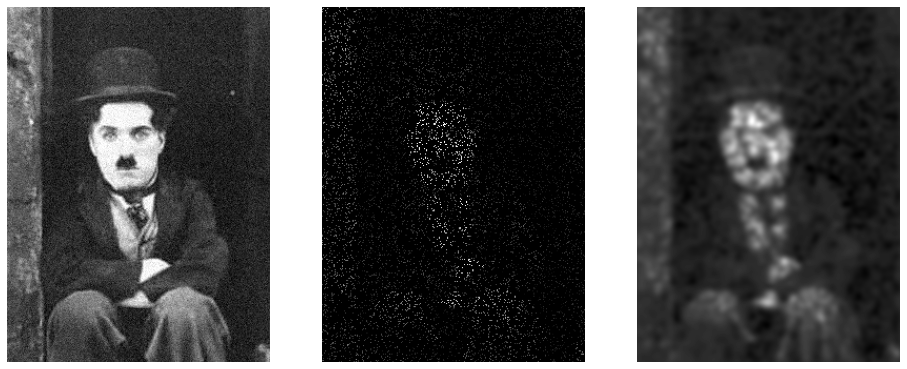

In [29]:
from PIL import Image

cc = np.asarray(Image.open("material/charlie-chaplin.jpg"))
cc_90 = np.asarray(Image.open("material/cc_90.png"))

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(cc, cmap="gray")
axes[0].axis("off")
axes[1].imshow(cc_90, cmap="gray")
axes[1].axis("off")
axes[2].imshow(cc_rec, cmap="gray")
axes[2].axis("off")
plt.axis("off")
plt.show()